# GO1 Cup Carrying in MuJoCo (SAC)
This notebook is the project code.

**What it does**:
1. Load Unitree Go1 from MuJoCo Menagerie
2. Add a **visual cup + water** on the trunk (MJCF patch)
3. Train a **Soft Actor-Critic (SAC)** walking policy
4. Fine-tune with a **stability reward wrapper** (reduced tilt / vertical motion)
5. Render a **2K follow-camera** demo video and generate plots for the report



In [ ]:
# === 0) Install dependencies (Colab) ===
!pip install -q "gymnasium[mujoco]>=1.0.0" "stable-baselines3[extra]" mujoco tensorboard imageio imageio-ffmpeg shimmy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 19.2 MB/s eta 0:00:00


In [ ]:
# === 1) Imports + Drive mount + paths ===
import os
os.environ["MUJOCO_GL"] = "egl"   # Colab offscreen rendering

import gymnasium as gym
import mujoco
import numpy as np
import imageio

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/go1_cup_sac"
MENAGERIE_DIR = os.path.join(BASE_DIR, "mujoco_menagerie")
GO1_DIR = os.path.join(MENAGERIE_DIR, "unitree_go1")

os.makedirs(BASE_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("MENAGERIE_DIR:", MENAGERIE_DIR)
print("GO1_DIR:", GO1_DIR)


Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/go1_cup_sac
MENAGERIE_DIR: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie
GO1_DIR: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1


In [ ]:
# === 2) Download MuJoCo Menagerie ===
if not os.path.exists(MENAGERIE_DIR):
    %cd $BASE_DIR
    !git clone https://github.com/google-deepmind/mujoco_menagerie.git
else:
    print("Menagerie already exists:", MENAGERIE_DIR)

SCENE_ORIG = os.path.join(GO1_DIR, "scene.xml")
GO1_ORIG   = os.path.join(GO1_DIR, "go1.xml")

print("SCENE_ORIG:", SCENE_ORIG, "exists:", os.path.exists(SCENE_ORIG))
print("GO1_ORIG  :", GO1_ORIG, "exists:", os.path.exists(GO1_ORIG))


Menagerie already exists: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie
SCENE_ORIG: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/scene.xml exists: True
GO1_ORIG  : /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/go1.xml exists: True


## Patch MJCF: add a cup (visual only) + water + follow camera
This creates two new XML files:
- `scene_cup_visual.xml` (includes follow camera + larger offscreen buffer)
- `go1_cup_visual.xml` (adds cup + water geoms on the trunk)

They are **purely visual** (massless + no collision) to keep training stable.

In [ ]:
# === 3) Patch the XMLs ===
import shutil
import xml.etree.ElementTree as ET

SCENE_CUP = os.path.join(GO1_DIR, "scene_cup_visual.xml")
GO1_CUP   = os.path.join(GO1_DIR, "go1_cup_visual.xml")

# Copy once
if not os.path.exists(SCENE_CUP):
    shutil.copy(SCENE_ORIG, SCENE_CUP)
    print("Created:", SCENE_CUP)
else:
    print("Exists:", SCENE_CUP)

if not os.path.exists(GO1_CUP):
    shutil.copy(GO1_ORIG, GO1_CUP)
    print("Created:", GO1_CUP)
else:
    print("Exists:", GO1_CUP)

# --- (A) scene: include go1_cup_visual.xml instead of go1.xml ---
tree_scene = ET.parse(SCENE_CUP)
root_scene = tree_scene.getroot()
changed = False
for inc in root_scene.iter("include"):
    f = inc.attrib.get("file", "")
    if f.endswith("go1.xml") and f != "go1_cup_visual.xml":
        inc.attrib["file"] = "go1_cup_visual.xml"
        changed = True
        print("include:", f, "->", inc.attrib["file"])
if changed:
    tree_scene.write(SCENE_CUP, encoding="utf-8", xml_declaration=True)
    print("Patched:", SCENE_CUP)

# --- (B) Add a follow camera in scene ---
tree_scene = ET.parse(SCENE_CUP)
root_scene = tree_scene.getroot()
worldbody = root_scene.find("worldbody")
if worldbody is None:
    raise RuntimeError("worldbody not found in scene_cup_visual.xml")

has_follow = any(cam.attrib.get("name") == "follow" for cam in worldbody.iter("camera"))
if not has_follow:
    ET.SubElement(
        worldbody, "camera",
        {"name":"follow","mode":"trackcom","pos":"0 -4 1.5","xyaxes":"1 0 0 0 0 1"}
    )
    tree_scene.write(SCENE_CUP, encoding="utf-8", xml_declaration=True)
    print("Added follow camera ->", SCENE_CUP)
else:
    print("follow camera already exists.")

# --- (C) Increase offscreen buffer for HD/2K rendering ---
tree_scene = ET.parse(SCENE_CUP)
root_scene = tree_scene.getroot()
visual = root_scene.find("visual")
if visual is None:
    visual = ET.SubElement(root_scene, "visual")
global_elem = visual.find("global")
if global_elem is None:
    global_elem = ET.SubElement(visual, "global")

global_elem.attrib["offwidth"] = "2048"
global_elem.attrib["offheight"] = "1152"
tree_scene.write(SCENE_CUP, encoding="utf-8", xml_declaration=True)
print("Set offscreen to 2048x1152 in", SCENE_CUP)

# --- (D) Add cup + water geoms on trunk (visual only) ---
model_tmp = mujoco.MjModel.from_xml_path(SCENE_ORIG)
trunk_name = mujoco.mj_id2name(model_tmp, mujoco.mjtObj.mjOBJ_BODY, 1)
print("Trunk body name:", trunk_name)

tree_go1 = ET.parse(GO1_CUP)
root_go1 = tree_go1.getroot()
worldbody_go1 = root_go1.find("worldbody")
assert worldbody_go1 is not None

trunk_elem = None
for body in worldbody_go1.iter("body"):
    if body.attrib.get("name") == trunk_name:
        trunk_elem = body
        break
assert trunk_elem is not None

def get_or_create_geom(parent, name):
    for g in parent.findall("geom"):
        if g.attrib.get("name") == name:
            return g
    return ET.SubElement(parent, "geom", {"name": name})

cup_geom = get_or_create_geom(trunk_elem, "cup_geom")
cup_geom.attrib.update({
    "type": "cylinder",
    "pos": "0 0 0.12",
    "size": "0.05 0.06",       # radius, half-height (m)
    "rgba": "0.9 0.9 0.9 0.4",  # semi-transparent
    "density": "0",
    "contype": "0",
    "conaffinity": "0",
})

water_geom = get_or_create_geom(trunk_elem, "cup_water")
water_geom.attrib.update({
    "type": "cylinder",
    "pos": "0 0 0.11",
    "size": "0.045 0.03",      # slightly smaller than cup
    "rgba": "0.2 0.4 1.0 0.7",  # blue-ish semi-transparent
    "density": "0",
    "contype": "0",
    "conaffinity": "0",
})

tree_go1.write(GO1_CUP, encoding="utf-8", xml_declaration=True)
print("Patched:", GO1_CUP)
print("SCENE_CUP:", SCENE_CUP)


Exists: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/scene_cup_visual.xml
Exists: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/go1_cup_visual.xml
follow camera already exists.
Set offscreen to 2048x1152 in /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/scene_cup_visual.xml
Trunk body name: trunk
Patched: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/go1_cup_visual.xml
SCENE_CUP: /content/drive/MyDrive/go1_cup_sac/mujoco_menagerie/unitree_go1/scene_cup_visual.xml


## Environment factory
We load the Go1 robot through the `Ant-v5` interface. Main setting: `frame_skip=25` and MuJoCo timestep 0.002 → **dt=0.05s**.

In [ ]:
# === 4) Make the Go1Cup environment ===
DEFAULT_CAMERA_CONFIG = {
    "trackbodyid": 1,
    "distance": 4.0,
    "lookat": np.array([0.0, 0.0, 0.5]),
    "elevation": -20.0,
    "azimuth": 90.0,
}

def make_go1cup_env(render_mode=None):
    env = gym.make(
        "Ant-v5",
        xml_file=SCENE_CUP,
        forward_reward_weight=1.0,
        ctrl_cost_weight=0.05,
        contact_cost_weight=5e-4,
        healthy_reward=1.0,
        main_body=1,
        healthy_z_range=(0.195, 0.75),
        include_cfrc_ext_in_observation=True,
        exclude_current_positions_from_observation=False,
        reset_noise_scale=0.1,
        frame_skip=25,            # dt=0.05
        max_episode_steps=1000,
        render_mode=render_mode,
        default_camera_config=DEFAULT_CAMERA_CONFIG,
    )
    return env

# Smoke test
env = make_go1cup_env()
obs, info = env.reset(seed=0)
print("Obs shape:", obs.shape, "dt:", env.unwrapped.dt)
for _ in range(10):
    obs, r, term, trunc, info = env.step(env.action_space.sample())
env.close()
print("Random rollout OK")


Obs shape: (115,) dt: 0.05
Random rollout OK


## Training (SAC)
This section trains a baseline SAC model. If you already trained, you can skip training and only **load** the saved `.zip` model.

In [ ]:
# === 5) SAC training setup ===
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

LOG_DIR   = os.path.join(BASE_DIR, "tb_logs_sac_go1cup")
MODEL_DIR = os.path.join(BASE_DIR, "models_sac_go1cup")
VIDEO_DIR = os.path.join(BASE_DIR, "videos_sac_go1cup_follow_2k")

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

def make_env_fn(seed: int = 0):
    def _init():
        e = make_go1cup_env(render_mode=None)
        e = Monitor(e)
        e.reset(seed=seed)
        return e
    return _init

n_envs = 4
train_env = DummyVecEnv([make_env_fn(i) for i in range(n_envs)])

eval_env = Monitor(make_go1cup_env(render_mode=None))

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=50_000 // n_envs,
    n_eval_episodes=5,
    deterministic=True,
    render=False,
)

print("LOG_DIR:", LOG_DIR)
print("MODEL_DIR:", MODEL_DIR)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


LOG_DIR: /content/drive/MyDrive/go1_cup_sac/tb_logs_sac_go1cup
MODEL_DIR: /content/drive/MyDrive/go1_cup_sac/models_sac_go1cup


In [ ]:
# === 6) Train baseline SAC ===

TOTAL_STEPS = 1_500_000

model = SAC(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    buffer_size=1_000_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto_0.2",
    target_update_interval=1,
    verbose=1,
    tensorboard_log=LOG_DIR,
    device="auto",
)

model.learn(
    total_timesteps=TOTAL_STEPS,
    callback=eval_callback,
    log_interval=10,
)

model.save(os.path.join(MODEL_DIR, "sac_go1cup_final"))
print("Saved final baseline ->", os.path.join(MODEL_DIR, "sac_go1cup_final.zip"))


## Fine-tuning: Stability reward wrapper
We add a small penalty on trunk tilt (roll/pitch) and root vertical velocity to make the motion visually more stable for carrying.

In [ ]:
# === 7) Stability reward wrapper + optional fine-tuning ===
class Go1StabilityWrapper(gym.Wrapper):
    def __init__(self, env, w_orient=0.2, w_zvel=0.1):
        super().__init__(env)
        self.w_orient = w_orient
        self.w_zvel = w_zvel

        model = self.env.unwrapped.model
        try:
            self._trunk_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "trunk")
        except Exception:
            self._trunk_id = 1

    def _get_roll_pitch(self):
        data = self.env.unwrapped.data
        q = data.body_xquat[self._trunk_id] if hasattr(data, "body_xquat") else data.xquat[self._trunk_id]
        qw, qx, qy, qz = q

        sinr_cosp = 2 * (qw*qx + qy*qz)
        cosr_cosp = 1 - 2 * (qx*qx + qy*qy)
        roll = np.arctan2(sinr_cosp, cosr_cosp)

        sinp = 2 * (qw*qy - qz*qx)
        pitch = np.pi/2*np.sign(sinp) if abs(sinp) >= 1 else np.arcsin(sinp)
        return roll, pitch

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        roll, pitch = self._get_roll_pitch()
        z_vel = float(self.env.unwrapped.data.qvel[2])

        orient_cost = float(roll*roll + pitch*pitch)
        z_cost = float(abs(z_vel))

        reward -= self.w_orient * orient_cost
        reward -= self.w_zvel * z_cost

        info = dict(info)
        info["orient_cost"] = orient_cost
        info["z_vel"] = z_vel
        return obs, reward, terminated, truncated, info

def make_env_stable(seed: int = 0):
    def _init():
        e = make_go1cup_env(render_mode=None)
        e = Go1StabilityWrapper(e, w_orient=0.2, w_zvel=0.1)
        e = Monitor(e)
        e.reset(seed=seed)
        return e
    return _init


In [ ]:
# === 8) Continue training with the stability wrapper ===

from stable_baselines3 import SAC

# Load best_model.zip if it exists, otherwise load final
best_model_path = os.path.join(MODEL_DIR, "best_model.zip")
final_model_path = os.path.join(MODEL_DIR, "sac_go1cup_final.zip")

if os.path.exists(best_model_path):
    sac_model = SAC.load(best_model_path, device="auto")
    print("Loaded baseline best_model.zip")
elif os.path.exists(final_model_path):
    sac_model = SAC.load(final_model_path, device="auto")
    print("Loaded baseline sac_go1cup_final.zip")
else:
    sac_model = model
    print("Using in-memory 'model' (you must have trained it in previous cell).")

n_envs = 4
train_env2 = DummyVecEnv([make_env_stable(i) for i in range(n_envs)])
sac_model.set_env(train_env2)

EXTRA_STEPS = 500_000
sac_model.learn(total_timesteps=EXTRA_STEPS, log_interval=10)

stable_path = os.path.join(MODEL_DIR, "sac_go1cup_stable")
sac_model.save(stable_path)
print("Saved stable ->", stable_path + ".zip")


In [ ]:
# === 9) Load the trained stable model ===
from stable_baselines3 import SAC

stable_model_path = os.path.join(MODEL_DIR, "sac_go1cup_stable")  # SB3 auto adds .zip
sac_model = SAC.load(stable_model_path, device="auto")
print("Loaded:", stable_model_path + ".zip")


Loaded: /content/drive/MyDrive/go1_cup_sac/models_sac_go1cup/sac_go1cup_stable.zip


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Render a 2K follow-camera video
We render via `mujoco.Renderer` using the XML camera named `follow`.
Set `fps=15` for slow-motion (looks smoother and more stable).

In [ ]:
# === 10) Record a 2K video (follow camera) ===
import mujoco

def record_video_2k(filename, max_steps=300, fps=15, seed=0, bitrate="16000k"):
    env = make_go1cup_env(render_mode=None)
    obs, info = env.reset(seed=seed)

    m = env.unwrapped.model
    d = env.unwrapped.data
    renderer = mujoco.Renderer(m)  # uses offwidth/offheight from XML

    writer = imageio.get_writer(filename, fps=fps, codec="libx264", bitrate=bitrate)

    for step in range(max_steps):
        action, _ = sac_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        renderer.update_scene(d, camera="follow")
        frame = renderer.render()
        writer.append_data(frame)

        if terminated or truncated:
            break

    writer.close()
    env.close()
    print("Saved:", filename)

# Example
out_path = os.path.join(VIDEO_DIR, "go1_cup_sac_stable_2k_seed0.mp4")
record_video_2k(out_path, max_steps=300, fps=15, seed=0)


## Evaluation metrics (spill proxy)
We don't simulate real liquid. Instead, we estimate spill risk using a **tilt threshold**:
$$\theta(t)=\sqrt{\mathrm{roll}(t)^2+\mathrm{pitch}(t)^2}$$
and `spill_ratio = fraction( θ > θ_spill )`.

This gives a simple, reproducible proxy metric for *"carrying liquid stably"*.

Baseline: {'rms_deg': 19.047801907326832, 'max_deg': 60.33817690573059, 'spill_threshold_deg': 15.0, 'spill_ratio_percent': 58.199999999999996, 'avg_speed_mps': 1.8833456817700185, 'num_samples': 5000}
Stable  : {'rms_deg': 18.451309595800197, 'max_deg': 168.2938156056199, 'spill_threshold_deg': 15.0, 'spill_ratio_percent': 53.646957272334916, 'avg_speed_mps': 2.5134023027257237, 'num_samples': 4634}
Saved figure: /content/drive/MyDrive/go1_cup_sac/report_figs/metrics_comparison_pretty.png


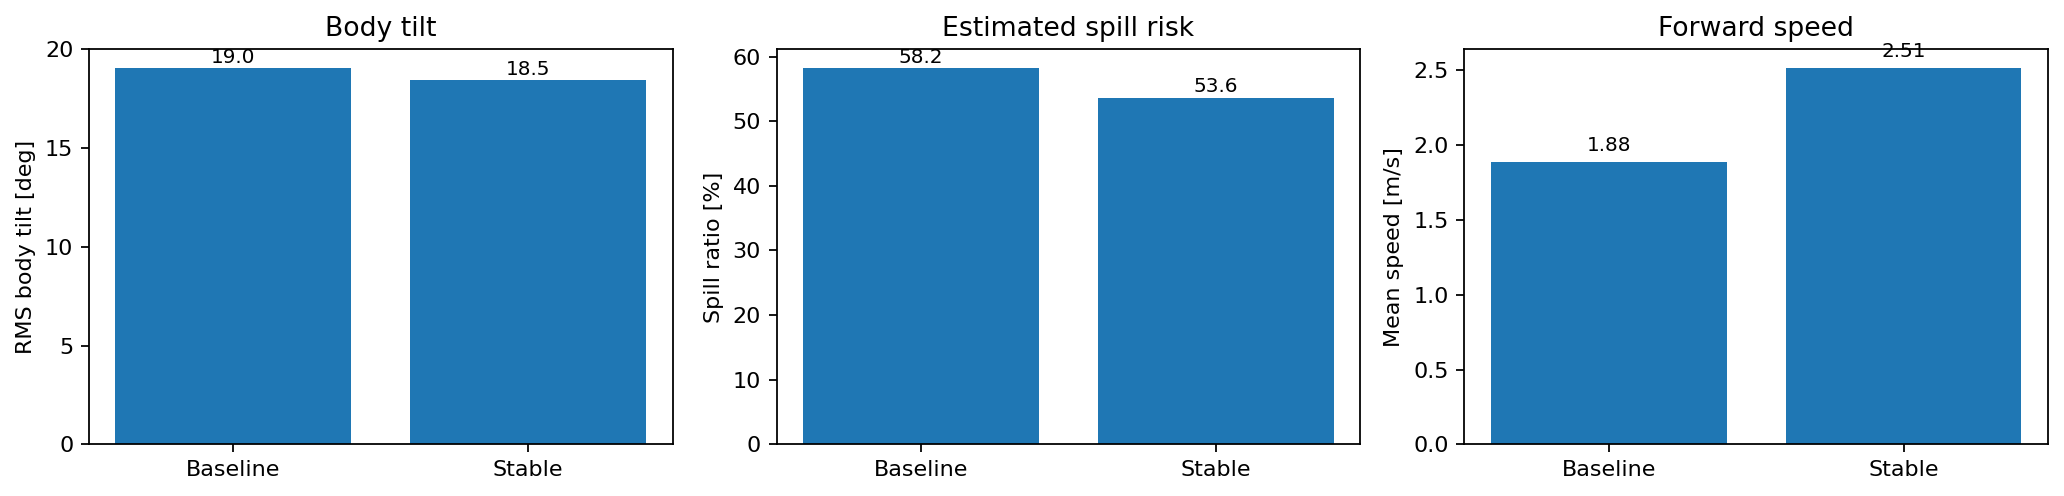

In [ ]:
# === 11) Evaluation + plots ===
import matplotlib.pyplot as plt

def get_trunk_roll_pitch(env):
    data = env.unwrapped.data
    model = env.unwrapped.model
    try:
        trunk_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "trunk")
    except Exception:
        trunk_id = 1
    q = data.body_xquat[trunk_id] if hasattr(data, "body_xquat") else data.xquat[trunk_id]
    qw, qx, qy, qz = q

    sinr_cosp = 2 * (qw*qx + qy*qz)
    cosr_cosp = 1 - 2 * (qx*qx + qy*qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    sinp = 2 * (qw*qy - qz*qx)
    pitch = np.pi/2*np.sign(sinp) if abs(sinp) >= 1 else np.arcsin(sinp)
    return roll, pitch

def eval_policy_metrics(model, num_episodes=5, max_steps=1000, theta_spill_deg=15.0):
    all_thetas = []
    total_dx = 0.0
    total_steps = 0
    dt_list = []

    for ep in range(num_episodes):
        env = make_go1cup_env(render_mode=None)
        obs, info = env.reset(seed=ep)
        data = env.unwrapped.data
        dt = env.unwrapped.dt
        dt_list.append(dt)

        last_x = float(data.qpos[0])

        for step in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)

            roll, pitch = get_trunk_roll_pitch(env)
            theta_body = np.sqrt(roll**2 + pitch**2)
            all_thetas.append(theta_body)

            x_now = float(data.qpos[0])
            total_dx += (x_now - last_x)
            last_x = x_now
            total_steps += 1

            if terminated or truncated:
                break
        env.close()

    theta_deg = np.rad2deg(np.array(all_thetas))
    spill_ratio = float(np.mean(theta_deg > theta_spill_deg)) * 100.0
    rms_deg = float(np.sqrt(np.mean(theta_deg**2)))
    max_deg = float(np.max(theta_deg))
    avg_dt = float(np.mean(dt_list)) if dt_list else 0.05
    avg_speed = float(total_dx / (total_steps * avg_dt)) if total_steps > 0 else 0.0

    return {
        "rms_deg": rms_deg,
        "max_deg": max_deg,
        "spill_threshold_deg": theta_spill_deg,
        "spill_ratio_percent": spill_ratio,
        "avg_speed_mps": avg_speed,
        "num_samples": int(theta_deg.size),
    }, theta_deg

# Load baseline and stable to compare
from stable_baselines3 import SAC
baseline_path = os.path.join(MODEL_DIR, "best_model.zip")  # baseline
stable_path   = os.path.join(MODEL_DIR, "sac_go1cup_stable.zip")

baseline_model = SAC.load(baseline_path, device="auto")
stable_model   = SAC.load(stable_path, device="auto")

baseline_metrics, _ = eval_policy_metrics(baseline_model, theta_spill_deg=15.0)
stable_metrics, _   = eval_policy_metrics(stable_model, theta_spill_deg=15.0)

print("Baseline:", baseline_metrics)
print("Stable  :", stable_metrics)

# Pretty bar chart for report
labels = ["Baseline", "Stable"]
tilt_vals  = [baseline_metrics["rms_deg"], stable_metrics["rms_deg"]]
spill_vals = [baseline_metrics["spill_ratio_percent"], stable_metrics["spill_ratio_percent"]]
speed_vals = [baseline_metrics["avg_speed_mps"], stable_metrics["avg_speed_mps"]]

fig, axes = plt.subplots(1, 3, figsize=(13, 3.2), dpi=160)

axes[0].bar(labels, tilt_vals)
axes[0].set_title("Body tilt")
axes[0].set_ylabel("RMS body tilt [deg]")
for i, v in enumerate(tilt_vals):
    axes[0].text(i, v + 0.05, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

axes[1].bar(labels, spill_vals)
axes[1].set_title("Estimated spill risk")
axes[1].set_ylabel("Spill ratio [%]")
for i, v in enumerate(spill_vals):
    axes[1].text(i, v + 0.2, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

axes[2].bar(labels, speed_vals)
axes[2].set_title("Forward speed")
axes[2].set_ylabel("Mean speed [m/s]")
for i, v in enumerate(speed_vals):
    axes[2].text(i, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

FIG_DIR = os.path.join(BASE_DIR, "report_figs")
os.makedirs(FIG_DIR, exist_ok=True)
fig_path = os.path.join(FIG_DIR, "metrics_comparison_pretty.png")
plt.savefig(fig_path, bbox_inches="tight")
print("Saved figure:", fig_path)
plt.show()


## (Optional) Export one frame as a report figure
This is useful to show *what the cup/water looks like* in the paper.

Saved: /content/drive/MyDrive/go1_cup_sac/report_figs/go1cup_frame.png


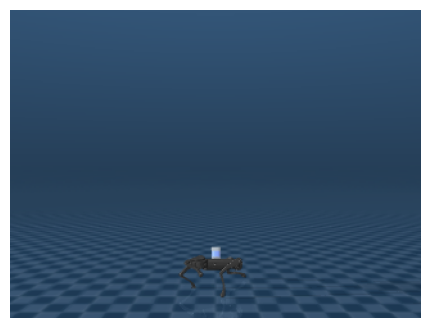

In [ ]:
# === 12) Export a running frame image (png) ===
import os
import mujoco
import imageio
import matplotlib.pyplot as plt

FIG_DIR = os.path.join(BASE_DIR, "report_figs")
os.makedirs(FIG_DIR, exist_ok=True)

CAPTURE_STEP = 120

env = make_go1cup_env(render_mode=None)
obs, info = env.reset(seed=0)

m = env.unwrapped.model
d = env.unwrapped.data
renderer = mujoco.Renderer(m)

for t in range(CAPTURE_STEP):
    action, _ = sac_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

renderer.update_scene(d, camera="follow")
img = renderer.render()

env.close()

png_path = os.path.join(FIG_DIR, "go1cup_frame.png")
imageio.imwrite(png_path, img)
print("Saved:", png_path)

plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis("off")
plt.show()


## Extra visual aids for the report (optional)
Run these cells to generate additional figures like time-series tilt curves and training curves.
They are **not required** for the demo video, but help the paper look more professional.

Saved: /content/drive/MyDrive/go1_cup_sac/report_figs/tilt_timeseries.png


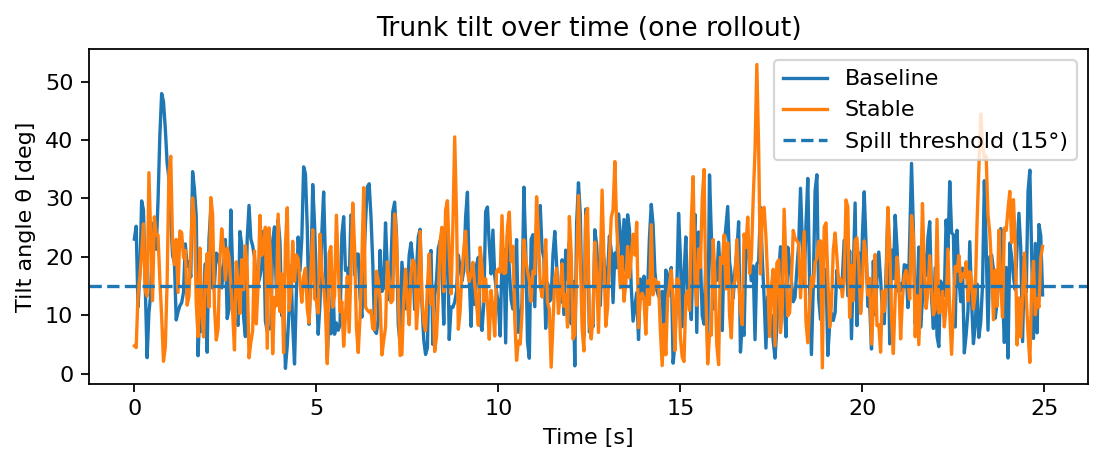

In [ ]:
# === 13) Tilt time-series (Baseline vs Stable) ===
import matplotlib.pyplot as plt
import numpy as np

def rollout_tilt_series(model, seed=0, max_steps=500):
    env = make_go1cup_env(render_mode=None)
    obs, info = env.reset(seed=seed)
    data = env.unwrapped.data
    dt = env.unwrapped.dt

    t_list = []
    theta_deg_list = []

    for step in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        roll, pitch = get_trunk_roll_pitch(env)
        theta = np.sqrt(roll**2 + pitch**2)
        theta_deg_list.append(np.rad2deg(theta))
        t_list.append(step * dt)

        if terminated or truncated:
            break

    env.close()
    return np.array(t_list), np.array(theta_deg_list)

t_b, th_b = rollout_tilt_series(baseline_model, seed=0, max_steps=500)
t_s, th_s = rollout_tilt_series(stable_model, seed=0, max_steps=500)

plt.figure(figsize=(7,3), dpi=160)
plt.plot(t_b, th_b, label="Baseline")
plt.plot(t_s, th_s, label="Stable")
plt.axhline(15.0, linestyle="--", label="Spill threshold (15°)")
plt.xlabel("Time [s]")
plt.ylabel("Tilt angle θ [deg]")
plt.title("Trunk tilt over time (one rollout)")
plt.legend(loc="upper right")
plt.tight_layout()

ts_path = os.path.join(FIG_DIR, "tilt_timeseries.png")
plt.savefig(ts_path, bbox_inches="tight")
print("Saved:", ts_path)
plt.show()


Saved: /content/drive/MyDrive/go1_cup_sac/report_figs/tilt_cdf.png


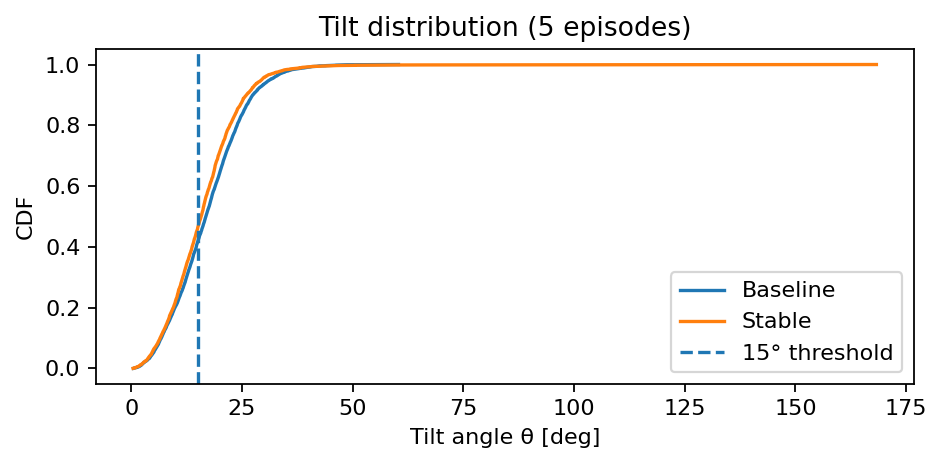

In [ ]:
# === 14) Tilt distribution (CDF) ===
import matplotlib.pyplot as plt
import numpy as np

# Recompute theta arrays for a fair comparison (same spill threshold)
_, theta_b = eval_policy_metrics(baseline_model, num_episodes=5, max_steps=1000, theta_spill_deg=15.0)
_, theta_s = eval_policy_metrics(stable_model,   num_episodes=5, max_steps=1000, theta_spill_deg=15.0)

def plot_cdf(theta_deg, label):
    x = np.sort(theta_deg)
    y = np.linspace(0, 1, len(x), endpoint=True)
    plt.plot(x, y, label=label)

plt.figure(figsize=(6,3), dpi=160)
plot_cdf(theta_b, "Baseline")
plot_cdf(theta_s, "Stable")
plt.axvline(15.0, linestyle="--", label="15° threshold")
plt.xlabel("Tilt angle θ [deg]")
plt.ylabel("CDF")
plt.title("Tilt distribution (5 episodes)")
plt.legend(loc="lower right")
plt.tight_layout()

cdf_path = os.path.join(FIG_DIR, "tilt_cdf.png")
plt.savefig(cdf_path, bbox_inches="tight")
print("Saved:", cdf_path)
plt.show()


Found event files: 3
Saved: /content/drive/MyDrive/go1_cup_sac/report_figs/training_curves.png


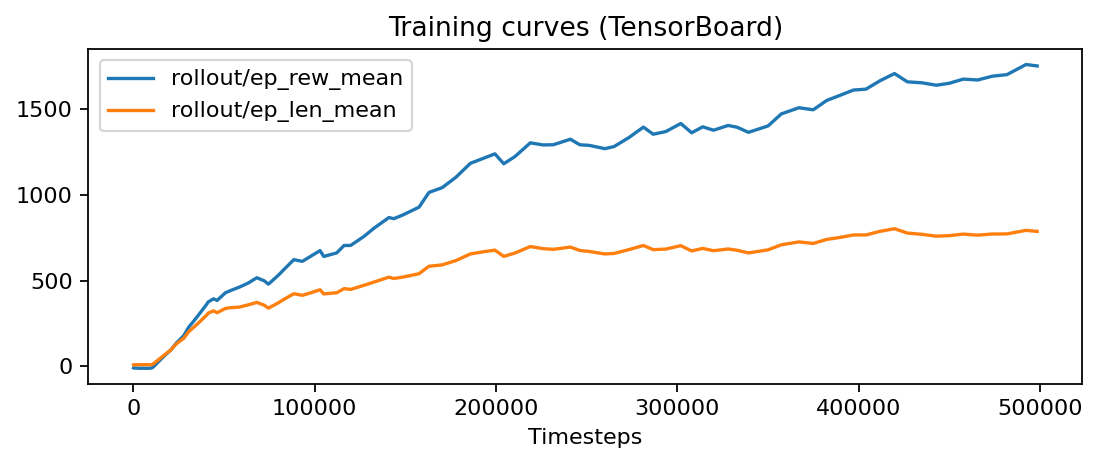

In [ ]:
# === 15) Training curve from TensorBoard logs (baseline SAC) ===
# This reads SB3 tensorboard event files and plots ep_rew_mean / ep_len_mean.
import os
import glob
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing import event_accumulator

event_files = glob.glob(os.path.join(LOG_DIR, "**", "events.out.tfevents.*"), recursive=True)
print("Found event files:", len(event_files))
if not event_files:
    print("No tensorboard logs found. Did you train with tensorboard_log=LOG_DIR?")
else:
    ea = event_accumulator.EventAccumulator(event_files[-1])
    ea.Reload()

    def read_scalar(tag):
        if tag not in ea.Tags().get("scalars", []):
            return None
        vals = ea.Scalars(tag)
        steps = [v.step for v in vals]
        scal  = [v.value for v in vals]
        return np.array(steps), np.array(scal)

    tags = ["rollout/ep_rew_mean", "rollout/ep_len_mean"]
    plt.figure(figsize=(7,3), dpi=160)
    for tag in tags:
        out = read_scalar(tag)
        if out is None:
            print("Missing tag:", tag)
            continue
        steps, scal = out
        plt.plot(steps, scal, label=tag)
    plt.xlabel("Timesteps")
    plt.title("Training curves (TensorBoard)")
    plt.legend()
    plt.tight_layout()

    curve_path = os.path.join(FIG_DIR, "training_curves.png")
    plt.savefig(curve_path, bbox_inches="tight")
    print("Saved:", curve_path)
    plt.show()


In [ ]:
import os, numpy as np, pandas as pd
from stable_baselines3 import SAC
import mujoco

BASE_DIR  = "/content/drive/MyDrive/go1_cup_sac"
MODEL_DIR = os.path.join(BASE_DIR, "models_sac_go1cup")

baseline_path = os.path.join(MODEL_DIR, "best_model.zip")          # baseline best
final_path    = os.path.join(MODEL_DIR, "sac_go1cup_final.zip")    # backup
stable_path   = os.path.join(MODEL_DIR, "sac_go1cup_stable.zip")   # stable

if os.path.exists(baseline_path):
    baseline_model = SAC.load(baseline_path, device="auto")
    print("Loaded baseline:", baseline_path)
else:
    baseline_model = SAC.load(final_path, device="auto")
    print("Loaded baseline:", final_path)

stable_model = SAC.load(stable_path, device="auto")
print("Loaded stable:", stable_path)

def get_trunk_roll_pitch(env):
    data = env.unwrapped.data
    model = env.unwrapped.model
    try:
        trunk_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "trunk")
    except Exception:
        trunk_id = 1

    q = data.body_xquat[trunk_id] if hasattr(data, "body_xquat") else data.xquat[trunk_id]
    qw, qx, qy, qz = q

    sinr_cosp = 2*(qw*qx + qy*qz)
    cosr_cosp = 1 - 2*(qx*qx + qy*qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    sinp = 2*(qw*qy - qz*qx)
    pitch = np.arcsin(np.clip(sinp, -1.0, 1.0))
    return roll, pitch

def eval_10s_metrics(model, num_episodes=10, horizon_steps=200, spill_th_deg=15.0, seed0=0):
    thetas = []
    spill_cnt = 0
    dx = 0.0
    steps = 0
    success = 0
    dt_list = []

    for ep in range(num_episodes):
        env = make_go1cup_env(render_mode=None)   # 你已经定义过的 env factory
        obs, info = env.reset(seed=seed0 + ep)

        dt = env.unwrapped.dt
        dt_list.append(dt)

        data = env.unwrapped.data
        last_x = float(data.qpos[0])

        alive = True
        for t in range(horizon_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, info = env.step(action)

            roll, pitch = get_trunk_roll_pitch(env)
            theta = np.sqrt(roll**2 + pitch**2)
            theta_deg = np.rad2deg(theta)
            thetas.append(theta_deg)
            spill_cnt += int(theta_deg > spill_th_deg)

            x_now = float(data.qpos[0])
            dx += (x_now - last_x)
            last_x = x_now
            steps += 1

            if terminated or truncated:
                alive = False
                break

        if alive:
            success += 1

        env.close()

    thetas = np.asarray(thetas)
    rms = float(np.sqrt(np.mean(thetas**2))) if len(thetas) else 0.0
    spill_ratio = 100.0 * float(spill_cnt) / float(max(steps, 1))
    avg_dt = float(np.mean(dt_list)) if dt_list else 0.05
    speed = float(dx / (steps * avg_dt)) if steps > 0 else 0.0
    success_rate = 100.0 * success / num_episodes

    return dict(
        rms_deg=rms,
        spill_ratio_percent=spill_ratio,
        avg_speed_mps=speed,
        success_rate_10s_percent=success_rate,
        samples=steps,
    )

rows = []
rows.append(("Baseline", 0.0, 0.0, eval_10s_metrics(baseline_model)))
rows.append(("Stable",   0.2, 0.1, eval_10s_metrics(stable_model)))

df = pd.DataFrame([{
    "Policy": name,
    "w_orient": wo,
    "w_z": wz,
    "Spill ratio (%)": m["spill_ratio_percent"],
    "Speed (m/s)": m["avg_speed_mps"],
    "10s success (%)": m["success_rate_10s_percent"],
    "RMS tilt (deg)": m["rms_deg"],
} for name, wo, wz, m in rows])

display(df)

latex = df[["w_orient","w_z","Spill ratio (%)","Speed (m/s)","10s success (%)"]].to_latex(
    index=False,
    float_format=lambda x: f"{x:.2f}",
)
print("\n===== LaTeX table body (copy into report) =====\n")
print(latex)


Loaded baseline: /content/drive/MyDrive/go1_cup_sac/models_sac_go1cup/best_model.zip
Loaded stable: /content/drive/MyDrive/go1_cup_sac/models_sac_go1cup/sac_go1cup_stable.zip


,Policy,w_orient,w_z,Spill ratio (%),Speed (m/s),10s success (%),RMS tilt (deg)
0,Baseline,0.0,0.0,58.45,1.876673,100.0,18.869539
1,Stable,0.2,0.1,54.05,2.289723,100.0,18.157579



===== LaTeX table body (copy into report) =====

\begin{tabular}{rrrrr}
\toprule
w_orient & w_z & Spill ratio (%) & Speed (m/s) & 10s success (%) \\
\midrule
0.00 & 0.00 & 58.45 & 1.88 & 100.00 \\
0.20 & 0.10 & 54.05 & 2.29 & 100.00 \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
